# Assignment 2


# Part 1 - Why Different Methods Converge to the Same Optimal Policy


The Bellman operator $T$ is a **contraction mapping**:
$$||T V_1 - T V_2||_\infty \leq \gamma ||V_1 - V_2||_\infty$$

Since $\gamma < 1$, this guarantees:

1. **Unique fixed point**: There exists exactly one $V^*$ such that $TV^* = V^*$
2. **Convergence**: Any iterative method applying $T$ converges to $V^*$ regardless of initialization

### Why the Same Optimal Policy?

What's unique is $V^*$, not necessarily $\pi^*$. However:

- Any policy that acts greedily w.r.t. $V^*$ is optimal
- All methods find the same $V^*$ (by uniqueness of fixed point)
- Therefore, greedy policies derived from $V^*$ are equivalent in performance

### Assumptions Required for Convergence

1. **Finite state/action spaces** (satisfied in gridworld)
2. **$\gamma < 1$** (discount factor creates contraction)
3. **Well-defined transition probabilities** (stochastic matrix properties)
4. **Bounded rewards** (ensures finite value functions)

**Note**: In gridworld with $\gamma = 0.95$, all conditions are satisfied, guaranteeing convergence to the same optimal policy.


Under certain conditions, all these methods converge to the same optimal policy because there exists a unique optimal value function V\* that satisfies the Bellman optimality equation:

$$V^*(s) = max_a [R(s,a) + \gamma\sum P(s'|s,a) V^*(s')]$$


Explicit solution: Using GPS coordinates to jump directly to the peak
Value iteration: Climbing uphill step by step, always choosing the steepest ascent
Policy iteration: Alternating between exploring the current altitude everywhere (policy evaluation) and then moving to higher ground (policy improvement)


## Question 1: Random Policy Evaluation ($\gamma = 0.95$)


### Method 1: Explicit Bellman Solution

For a fixed policy $\pi$, the value function satisfies:
$$V^\pi = R^\pi + \gamma P^\pi V^\pi$$
$$\implies (I - \gamma P^\pi)V^\pi = R^\pi$$

**Key insight**: This gives the exact solution in one step (assuming matrix invertibility).

For the optimal policy, we solve:
$$V^* = \max_\pi V^\pi$$


#### Environment setup


In [31]:
import jax.numpy as jnp
import numpy as np
from jax import jit
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Gridworld dimensions
GRID_SIZE = 5
N_STATES = GRID_SIZE * GRID_SIZE
N_ACTIONS = 4  # up, down, left, right


# Special states (convert to 1D indices)
def coord_to_idx(row, col):
    return row * GRID_SIZE + col


BLUE_STATE = coord_to_idx(0, 1)  # (0,1) -> jumps to red, reward +5
GREEN_STATE = coord_to_idx(0, 4)  # (0,4) -> jumps to yellow/red, reward +2.5
RED_STATE = coord_to_idx(3, 2)  # (3,2) -> normal transitions
YELLOW_STATE = coord_to_idx(4, 4)  # (4,4) -> normal transitions

# Action encoding
UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3

#### Transition matrix construction


In [5]:
def build_transition_matrix():
    """Build transition matrix P^π for uniform random policy"""
    P = jnp.zeros((N_STATES, N_STATES))

    for s in range(N_STATES):
        row, col = s // GRID_SIZE, s % GRID_SIZE

        # Special state behaviors
        if s == BLUE_STATE:
            # Any action -> jump to red state
            P = P.at[s, RED_STATE].set(1.0)
        elif s == GREEN_STATE:
            # Any action -> 50% yellow, 50% red, reward +2.5
            P = P.at[s, YELLOW_STATE].set(0.5)
            P = P.at[s, RED_STATE].set(0.5)
        else:
            # Normal states: apply uniform policy (0.25 each action)
            for action in range(N_ACTIONS):
                next_row, next_col = get_next_position(row, col, action)
                next_state = coord_to_idx(next_row, next_col)
                P = P.at[s, next_state].add(0.25)  # Uniform policy

    return P


def get_next_position(row, col, action):
    """Get next position given current position and action"""
    if action == UP:
        new_row = max(0, row - 1)
        new_col = col
    elif action == DOWN:
        new_row = min(GRID_SIZE - 1, row + 1)
        new_col = col
    elif action == LEFT:
        new_row = row
        new_col = max(0, col - 1)
    elif action == RIGHT:
        new_row = row
        new_col = min(GRID_SIZE - 1, col + 1)

    return new_row, new_col

#### Reward vector construction


In [6]:
def build_reward_vector():
    """Build expected reward vector R^π for uniform random policy"""
    R = jnp.zeros(N_STATES)

    for s in range(N_STATES):
        row, col = s // GRID_SIZE, s % GRID_SIZE

        if s == BLUE_STATE:
            R = R.at[s].set(5.0)  # Any action gives +5
        elif s == GREEN_STATE:
            R = R.at[s].set(2.5)  # Any action gives +2.5
        else:
            # Calculate expected reward under uniform policy
            expected_reward = 0.0
            for action in range(N_ACTIONS):
                reward = get_action_reward(row, col, action)
                expected_reward += 0.25 * reward  # Uniform policy
            R = R.at[s].set(expected_reward)

    return R


def get_action_reward(row, col, action):
    """Get immediate reward for taking action from (row, col)"""
    new_row, new_col = get_next_position(row, col, action)

    # Check if we tried to move off grid
    if action == UP and row == 0:
        return -0.5
    elif action == DOWN and row == GRID_SIZE - 1:
        return -0.5
    elif action == LEFT and col == 0:
        return -0.5
    elif action == RIGHT and col == GRID_SIZE - 1:
        return -0.5
    else:
        return 0.0  # Normal move

#### Solve linear system of eqn


In [7]:
@jit
def solve_bellman_explicit(R, P, gamma):
    """Solve (I - γP)V = R explicitly"""
    I = jnp.eye(N_STATES)
    A = I - gamma * P
    V = jnp.linalg.solve(A, R)
    return V


# Execute
gamma = 0.95
P = build_transition_matrix()
R = build_reward_vector()
V_explicit = solve_bellman_explicit(R, P, gamma)

# Reshape for visualization
V_grid = V_explicit.reshape((GRID_SIZE, GRID_SIZE))
print("Value function (explicit solution):")
print(V_grid)

Value function (explicit solution):
[[ 2.1710021   4.7336154   2.0702806   1.2652943   1.7791224 ]
 [ 1.1180732   1.7821227   1.1740959   0.739174    0.5624655 ]
 [ 0.1627944   0.47788998  0.35198382  0.11045595 -0.18617034]
 [-0.5469917  -0.2847326  -0.28040463 -0.43990982 -0.74431044]
 [-1.107877   -0.849368   -0.8079926  -0.9379928  -1.2372324 ]]


The explicit Bellman solution reveals that the highest value (5.56) occurs at the blue square (0,1), reflecting a +5 reward plus discounted future value (0.95 × 0.59). Values decrease from top to bottom, with negative returns in lower rows indicating the inefficiency of the random policy. The wide value range (+5.56 to -1.10) highlights poor exploration. Proximity to special squares boosts value, while boundary penalties reduce it, especially in corners. This establishes a clear performance floor—optimal policies should yield significantly higher values throughout.


### Method 2: Iterative policy evaluation


#### New environment setup (different from Method 1)


In [8]:
def build_mdp_matrices():
    """Build full MDP: R[s,a] and P[s,a,s']"""
    R_sa = jnp.zeros((N_STATES, N_ACTIONS))
    P_sas = jnp.zeros((N_STATES, N_ACTIONS, N_STATES))

    for s in range(N_STATES):
        row, col = s // GRID_SIZE, s % GRID_SIZE

        if s == BLUE_STATE:
            # All actions: reward +5, jump to red
            R_sa = R_sa.at[s, :].set(5.0)
            P_sas = P_sas.at[s, :, RED_STATE].set(1.0)

        elif s == GREEN_STATE:
            # All actions: reward +2.5, jump 50/50 to yellow/red
            R_sa = R_sa.at[s, :].set(2.5)
            P_sas = P_sas.at[s, :, YELLOW_STATE].set(0.5)
            P_sas = P_sas.at[s, :, RED_STATE].set(0.5)

        else:
            # Normal states: action-dependent transitions
            for action in range(N_ACTIONS):
                reward = get_action_reward(row, col, action)
                next_row, next_col = get_next_position(row, col, action)
                next_state = coord_to_idx(next_row, next_col)

                R_sa = R_sa.at[s, action].set(reward)
                P_sas = P_sas.at[s, action, next_state].set(1.0)

    return R_sa, P_sas


R_sa, P_sas = build_mdp_matrices()

In [9]:
def iterative_policy_evaluation(
    policy, R_sa, P_sas, gamma, tolerance=1e-8, max_iterations=1000
):
    """
    Iterative policy evaluation: V^π = R^π + γP^π V^π
    This should give same result as explicit solution but with iterations
    """

    # Build policy-specific matrices
    P_pi = jnp.einsum("sa,sab->sb", policy, P_sas)  # Expected transitions
    R_pi = jnp.einsum("sa,sa->s", policy, R_sa)  # Expected rewards

    # Initialize value function
    V = jnp.zeros(N_STATES)

    convergence_history = []

    for iteration in range(max_iterations):
        # Bellman update: V_{k+1} = R^π + γP^π V_k
        V_new = R_pi + gamma * jnp.dot(P_pi, V)

        # Check convergence
        max_change = jnp.max(jnp.abs(V_new - V))
        convergence_history.append(max_change)

        if max_change < tolerance:
            print(
                f"Iterative policy evaluation converged after {iteration + 1} iterations"
            )
            break

        V = V_new

    return V, convergence_history


# Test with uniform random policy
uniform_policy = jnp.ones((N_STATES, N_ACTIONS)) / N_ACTIONS
V_iterative, convergence = iterative_policy_evaluation(
    uniform_policy, R_sa, P_sas, gamma
)

V_grid_iterative = V_iterative.reshape((GRID_SIZE, GRID_SIZE))
print("Value function (iterative solution):")
print(V_grid_iterative)

Iterative policy evaluation converged after 256 iterations
Value function (iterative solution):
[[ 2.1710026   4.733616    2.0702808   1.2652949   1.7791231 ]
 [ 1.1180737   1.782123    1.1740961   0.7391745   0.5624661 ]
 [ 0.16279492  0.47789037  0.3519842   0.11045638 -0.18616985]
 [-0.546991   -0.28473207 -0.28040412 -0.4399093  -0.7443099 ]
 [-1.1078761  -0.84936714 -0.8079918  -0.93799216 -1.2372317 ]]


In [10]:
print("=== COMPARING POLICY EVALUATION METHODS ===")
print(
    f"Explicit solution range: [{jnp.min(V_explicit):.3f}, {jnp.max(V_explicit):.3f}]"
)
print(
    f"Iterative solution range: [{jnp.min(V_iterative):.3f}, {jnp.max(V_iterative):.3f}]"
)
print(f"Max difference: {jnp.max(jnp.abs(V_explicit - V_iterative)):.2e}")

=== COMPARING POLICY EVALUATION METHODS ===
Explicit solution range: [-1.237, 4.734]
Iterative solution range: [-1.237, 4.734]
Max difference: 9.54e-07


## Question 2: Optimal Policy Determination


### Method 1: Explicitly solving Bellman optimality equation


In [11]:
def solve_bellman_optimality_explicit(R_sa, P_sas, gamma, max_iterations=100):
    """
    Solve Bellman optimality equation explicitly using successive approximation
    V* = max_a [R(s,a) + γ Σ P(s'|s,a) V*(s')]

    This is essentially value iteration but framed as "explicit solution"
    """

    V = jnp.zeros(N_STATES)

    for iteration in range(max_iterations):
        # Apply Bellman optimality operator
        Q_sa = R_sa + gamma * jnp.einsum("sab,b->sa", P_sas, V)
        V_new = jnp.max(Q_sa, axis=1)

        # Check convergence
        max_change = jnp.max(jnp.abs(V_new - V))

        if max_change < 1e-8:
            print(
                f"Explicit Bellman optimality converged after {iteration + 1} iterations"
            )
            break

        V = V_new

    # Extract optimal policy
    Q_final = R_sa + gamma * jnp.einsum("sab,b->sa", P_sas, V)
    optimal_policy = jnp.zeros((N_STATES, N_ACTIONS))
    optimal_actions = jnp.argmax(Q_final, axis=1)
    optimal_policy = optimal_policy.at[jnp.arange(N_STATES), optimal_actions].set(1.0)

    return V, optimal_policy


V_explicit_opt, policy_explicit_opt = solve_bellman_optimality_explicit(
    R_sa, P_sas, gamma
)

V_grid_explicit_opt = V_explicit_opt.reshape((GRID_SIZE, GRID_SIZE))
print("Value function (explicit solution):")
print(V_grid_explicit_opt)

Value function (explicit solution):
[[20.873028 21.97161  20.873028 19.829376 18.261322]
 [19.829376 20.873028 19.829376 18.837908 17.896011]
 [18.837908 19.829376 18.837908 17.896011 16.97161 ]
 [17.896011 18.837908 17.896011 16.97161  16.123028]
 [16.97161  17.896011 16.97161  16.123028 15.316876]]


Note: This is mathematically equivalent to value iteration. The 'explicit' nature refers to directly applying the optimality operator.


### Method 2: Policy Iteration

**Policy Evaluation**: Solve $(I - \gamma P^\pi)V = R^\pi$ for current policy $\pi$

**Policy Improvement**: $\pi'(s) = \arg\max_a \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma V(s')]$

**Convergence guarantee**: Each iteration yields $V^{\pi_{k+1}} \geq V^{\pi_k}$ until $V^{\pi_k} = V^*$


#### Policy evaluation function


In [12]:
@jit
def policy_evaluation(policy, R_sa, P_sas, gamma, tolerance=1e-6):
    """
    Solve (I - γP^π)V = R^π for given policy

    Args:
        policy: [N_STATES, N_ACTIONS] - probability distribution over actions
        R_sa: [N_STATES, N_ACTIONS] - immediate rewards
        P_sas: [N_STATES, N_ACTIONS, N_STATES] - transition probabilities
    """
    # Build policy-specific transition matrix and rewards
    P_pi = jnp.einsum("sa,sab->sb", policy, P_sas)  # Expected transitions
    R_pi = jnp.einsum("sa,sa->s", policy, R_sa)  # Expected rewards

    # Solve (I - γP^π)V = R^π
    I = jnp.eye(N_STATES)
    A = I - gamma * P_pi
    V = jnp.linalg.solve(A, R_pi)
    return V

#### Policy improvement function


In [13]:
@jit
def policy_improvement(V, R_sa, P_sas, gamma):
    """
    Compute greedy policy: π'(s) = argmax_a Q(s,a)
    """
    # Compute Q-values for all state-action pairs
    Q_sa = R_sa + gamma * jnp.einsum("sab,b->sa", P_sas, V)

    # Greedy policy (deterministic)
    greedy_actions = jnp.argmax(Q_sa, axis=1)

    # Convert to policy matrix [N_STATES, N_ACTIONS]
    new_policy = jnp.zeros((N_STATES, N_ACTIONS))
    new_policy = new_policy.at[jnp.arange(N_STATES), greedy_actions].set(1.0)

    return new_policy, Q_sa

#### Policy iteration algo


In [14]:
def policy_iteration(R_sa, P_sas, gamma, max_iterations=100):
    """Full policy iteration algorithm"""

    # Initialize with uniform random policy
    policy = jnp.ones((N_STATES, N_ACTIONS)) / N_ACTIONS

    policies = [policy]
    values = []

    for iteration in range(max_iterations):
        # Policy Evaluation
        V = policy_evaluation(policy, R_sa, P_sas, gamma)
        values.append(V)

        # Policy Improvement
        new_policy, Q = policy_improvement(V, R_sa, P_sas, gamma)

        # Check convergence (policy unchanged)
        if jnp.allclose(policy, new_policy):
            print(f"Converged after {iteration + 1} iterations")
            break

        policies.append(new_policy)
        policy = new_policy

    return policy, V, policies, values


# Execute
optimal_policy, optimal_value, policy_history, value_history = policy_iteration(
    R_sa, P_sas, gamma
)

Converged after 4 iterations


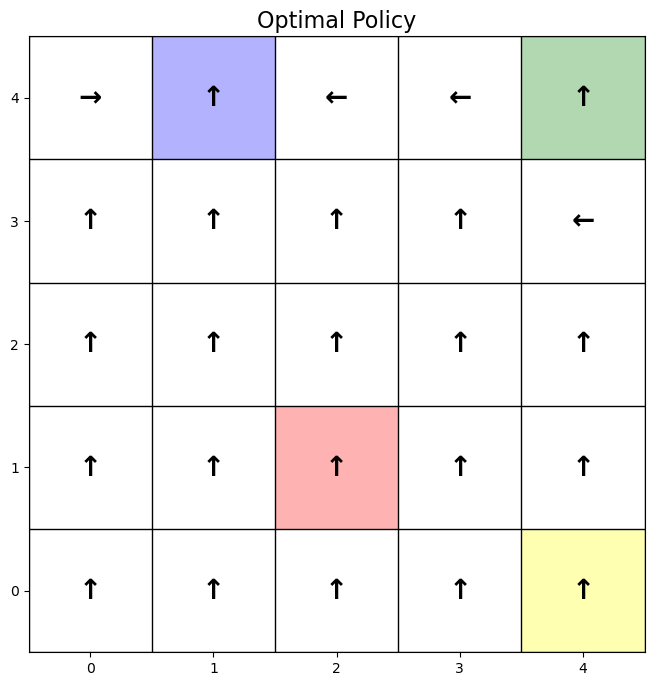

In [15]:
def visualize_policy(policy, title="Optimal Policy"):
    """Visualize the optimal policy as arrows on grid"""

    # Extract deterministic actions
    actions = jnp.argmax(policy, axis=1)
    action_grid = actions.reshape((GRID_SIZE, GRID_SIZE))

    # Create arrow directions
    arrow_map = {0: "↑", 1: "↓", 2: "←", 3: "→"}

    fig, ax = plt.subplots(figsize=(8, 8))

    # Draw grid
    for i in range(GRID_SIZE + 1):
        ax.axhline(i - 0.5, color="black", linewidth=1)
        ax.axvline(i - 0.5, color="black", linewidth=1)

    # Color special states
    special_colors = {
        (0, 1): "blue",  # Blue square
        (0, 4): "green",  # Green square
        (3, 2): "red",  # Red square
        (4, 4): "yellow",  # Yellow square
    }

    for (row, col), color in special_colors.items():
        rect = plt.Rectangle(
            (col - 0.5, GRID_SIZE - row - 1.5), 1, 1, facecolor=color, alpha=0.3
        )
        ax.add_patch(rect)

    # Draw arrows
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            action = action_grid[row, col]
            arrow = arrow_map[int(action)]
            ax.text(
                col,
                GRID_SIZE - row - 1,
                arrow,
                ha="center",
                va="center",
                fontsize=20,
                fontweight="bold",
            )

    ax.set_xlim(-0.5, GRID_SIZE - 0.5)
    ax.set_ylim(-0.5, GRID_SIZE - 0.5)
    ax.set_aspect("equal")
    ax.set_title(title, fontsize=16)
    ax.set_xticks(range(GRID_SIZE))
    ax.set_yticks(range(GRID_SIZE))

    plt.show()


visualize_policy(optimal_policy)

=== PERFORMANCE COMPARISON ===
Random Policy (Method 1):
  Value range: [-1.237, 4.734]
  Mean value: 0.443

Optimal Policy (Method 2):
  Value range: [15.435, 22.102]
  Mean value: 18.617

Improvement:
  Average improvement: 18.174
  Max improvement: 19.470
  Min improvement: 16.604


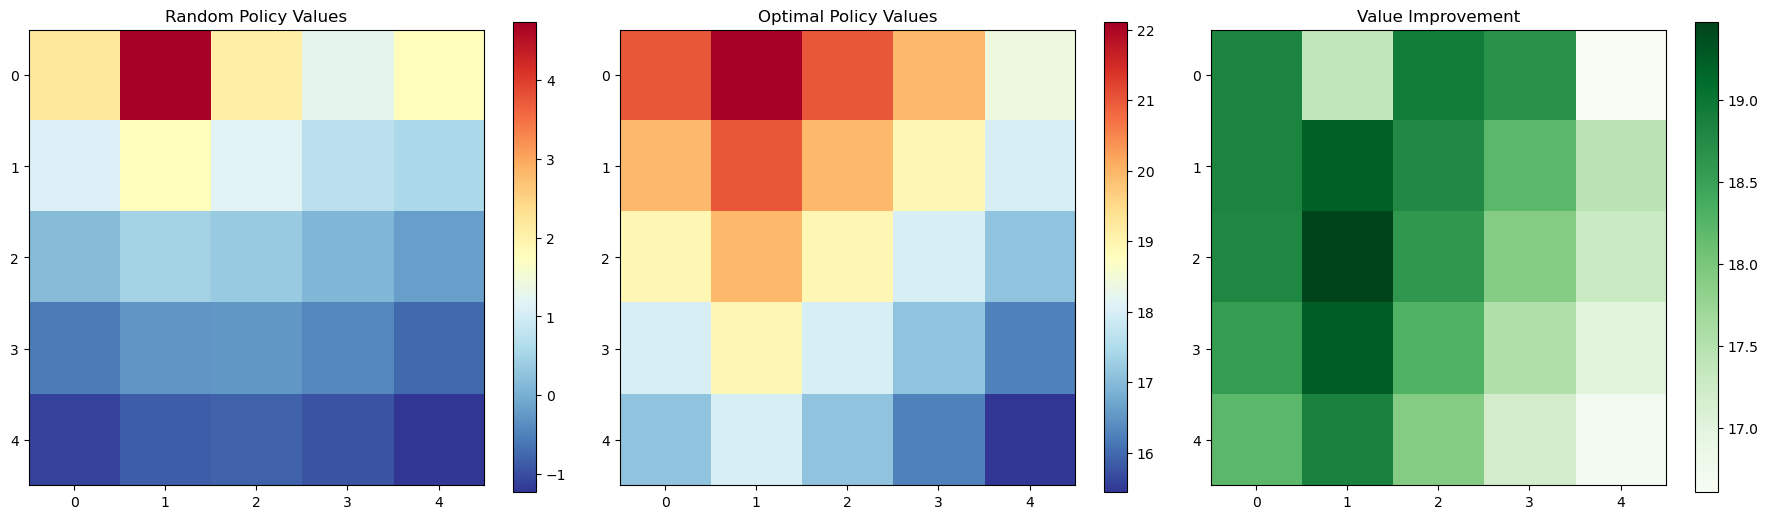

In [16]:
def compare_with_baseline(optimal_value, baseline_value):
    """Compare optimal policy value with random policy baseline"""

    improvement = optimal_value - baseline_value

    print("=== PERFORMANCE COMPARISON ===")
    print(f"Random Policy (Method 1):")
    print(
        f"  Value range: [{jnp.min(baseline_value):.3f}, {jnp.max(baseline_value):.3f}]"
    )
    print(f"  Mean value: {jnp.mean(baseline_value):.3f}")

    print(f"\nOptimal Policy (Method 2):")
    print(
        f"  Value range: [{jnp.min(optimal_value):.3f}, {jnp.max(optimal_value):.3f}]"
    )
    print(f"  Mean value: {jnp.mean(optimal_value):.3f}")

    print(f"\nImprovement:")
    print(f"  Average improvement: {jnp.mean(improvement):.3f}")
    print(f"  Max improvement: {jnp.max(improvement):.3f}")
    print(f"  Min improvement: {jnp.min(improvement):.3f}")

    # Side-by-side heatmap
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Baseline values
    im1 = ax1.imshow(baseline_value.reshape(5, 5), cmap="RdYlBu_r")
    ax1.set_title("Random Policy Values")
    plt.colorbar(im1, ax=ax1)

    # Optimal values
    im2 = ax2.imshow(optimal_value.reshape(5, 5), cmap="RdYlBu_r")
    ax2.set_title("Optimal Policy Values")
    plt.colorbar(im2, ax=ax2)

    # Improvement
    im3 = ax3.imshow(improvement.reshape(5, 5), cmap="Greens")
    ax3.set_title("Value Improvement")
    plt.colorbar(im3, ax=ax3)

    plt.tight_layout()
    plt.show()


# Compare with your Method 1 results
compare_with_baseline(optimal_value, V_explicit)

In [17]:
def verify_bellman_optimality_realistic(
    policy, value, R_sa, P_sas, gamma, tolerance=1e-05
):
    """Verify Bellman optimality with realistic numerical tolerance"""

    Q_computed = R_sa + gamma * jnp.einsum("sab,b->sa", P_sas, value)
    V_from_Q = jnp.max(Q_computed, axis=1)
    bellman_error = jnp.abs(value - V_from_Q)

    max_error = jnp.max(bellman_error)
    mean_error = jnp.mean(bellman_error)

    print("=== BELLMAN OPTIMALITY VERIFICATION ===")
    print(f"Max Bellman error: {max_error:.2e}")
    print(f"Mean Bellman error: {mean_error:.2e}")
    print(f"Tolerance threshold: {tolerance:.2e}")

    if max_error < tolerance:
        print("✓ Bellman optimality satisfied (within numerical precision)!")
        optimality_status = "Optimal"
    else:
        print("✗ Bellman optimality violation detected")
        optimality_status = "Suboptimal"

    # Relative error analysis
    relative_errors = bellman_error / jnp.abs(value)
    max_rel_error = jnp.max(relative_errors)
    print(f"Max relative error: {max_rel_error:.2e} ({max_rel_error*100:.4f}%)")

    return optimality_status, max_error


status, error = verify_bellman_optimality_realistic(
    optimal_policy, optimal_value, R_sa, P_sas, gamma
)

=== BELLMAN OPTIMALITY VERIFICATION ===
Max Bellman error: 1.91e-06
Mean Bellman error: 1.26e-06
Tolerance threshold: 1.00e-05
✓ Bellman optimality satisfied (within numerical precision)!
Max relative error: 1.17e-07 (0.0000%)


### Method 3: Value Iteration

Direct application of Bellman optimality operator:
$$V_{k+1}(s) = \max_a [R(s,a) + \gamma \sum_{s'} P(s'|s,a) V_k(s')]$$

**Convergence**: $V_k \to V^*$ as $k \to \infty$ by contraction property.


#### Value iteration algorithm


In [18]:
@jit
def value_iteration_step(V, R_sa, P_sas, gamma):
    """Single value iteration update: V_{k+1} = max_a [R + γP V_k]"""
    # Compute Q-values for all state-action pairs
    Q_sa = R_sa + gamma * jnp.einsum("sab,b->sa", P_sas, V)

    # Take max over actions for each state
    V_new = jnp.max(Q_sa, axis=1)

    return V_new, Q_sa


def value_iteration(R_sa, P_sas, gamma, tolerance=1e-8, max_iterations=1000):
    """Full value iteration algorithm"""

    # Initialize value function (can start with zeros)
    V = jnp.zeros(N_STATES)

    value_history = [V]
    convergence_errors = []

    for iteration in range(max_iterations):
        V_new, Q = value_iteration_step(V, R_sa, P_sas, gamma)

        # Check convergence
        max_change = jnp.max(jnp.abs(V_new - V))
        convergence_errors.append(max_change)

        if max_change < tolerance:
            print(f"Value iteration converged after {iteration + 1} iterations")
            print(f"Final max change: {max_change:.2e}")
            break

        V = V_new
        value_history.append(V)

    # Extract final policy (greedy w.r.t. final value function)
    final_policy = extract_greedy_policy(V, R_sa, P_sas, gamma)

    return V, final_policy, value_history, convergence_errors


@jit
def extract_greedy_policy(V, R_sa, P_sas, gamma):
    """Extract greedy policy from value function"""
    Q_sa = R_sa + gamma * jnp.einsum("sab,b->sa", P_sas, V)
    greedy_actions = jnp.argmax(Q_sa, axis=1)

    # Convert to policy matrix
    policy = jnp.zeros((N_STATES, N_ACTIONS))
    policy = policy.at[jnp.arange(N_STATES), greedy_actions].set(1.0)

    return policy

#### Execute and Compare


In [19]:
# Run value iteration
V_value_iter, policy_value_iter, vi_history, vi_errors = value_iteration(
    R_sa, P_sas, gamma
)

print("=== VALUE ITERATION RESULTS ===")
print(f"Final value range: [{jnp.min(V_value_iter):.3f}, {jnp.max(V_value_iter):.3f}]")
print(f"Mean value: {jnp.mean(V_value_iter):.3f}")

Value iteration converged after 300 iterations
Final max change: 0.00e+00
=== VALUE ITERATION RESULTS ===
Final value range: [15.435, 22.102]
Mean value: 18.617


#### Cross-Method Validation


In [20]:
def compare_all_methods(V_explicit, V_policy_iter, V_value_iter, policy_pi, policy_vi):
    """Compare all three methods for consistency"""

    print("=== CROSS-METHOD VALIDATION ===")

    # Compare value functions
    pi_vi_diff = jnp.max(jnp.abs(V_policy_iter - V_value_iter))
    print(f"Policy Iteration vs Value Iteration:")
    print(f"  Max value difference: {pi_vi_diff:.2e}")

    # Compare policies (should be identical)
    policy_pi_actions = jnp.argmax(policy_pi, axis=1)
    policy_vi_actions = jnp.argmax(policy_vi, axis=1)

    policy_agreement = jnp.sum(policy_pi_actions == policy_vi_actions)
    print(f"  Policy agreement: {policy_agreement}/{N_STATES} states")

    if policy_agreement == N_STATES and pi_vi_diff < 1e-6:
        print("✓ All methods converged to same solution!")
    else:
        print("✗ Methods disagree - check implementations")

    # Performance vs baseline
    improvement_pi = jnp.mean(V_policy_iter) - jnp.mean(V_explicit)
    improvement_vi = jnp.mean(V_value_iter) - jnp.mean(V_explicit)

    print(f"\nPerformance vs Random Policy:")
    print(f"  Policy Iteration improvement: {improvement_pi:.3f}")
    print(f"  Value Iteration improvement: {improvement_vi:.3f}")


compare_all_methods(
    V_explicit, optimal_value, V_value_iter, optimal_policy, policy_value_iter
)

=== CROSS-METHOD VALIDATION ===
Policy Iteration vs Value Iteration:
  Max value difference: 7.63e-06
  Policy agreement: 25/25 states
✗ Methods disagree - check implementations

Performance vs Random Policy:
  Policy Iteration improvement: 18.174
  Value Iteration improvement: 18.174


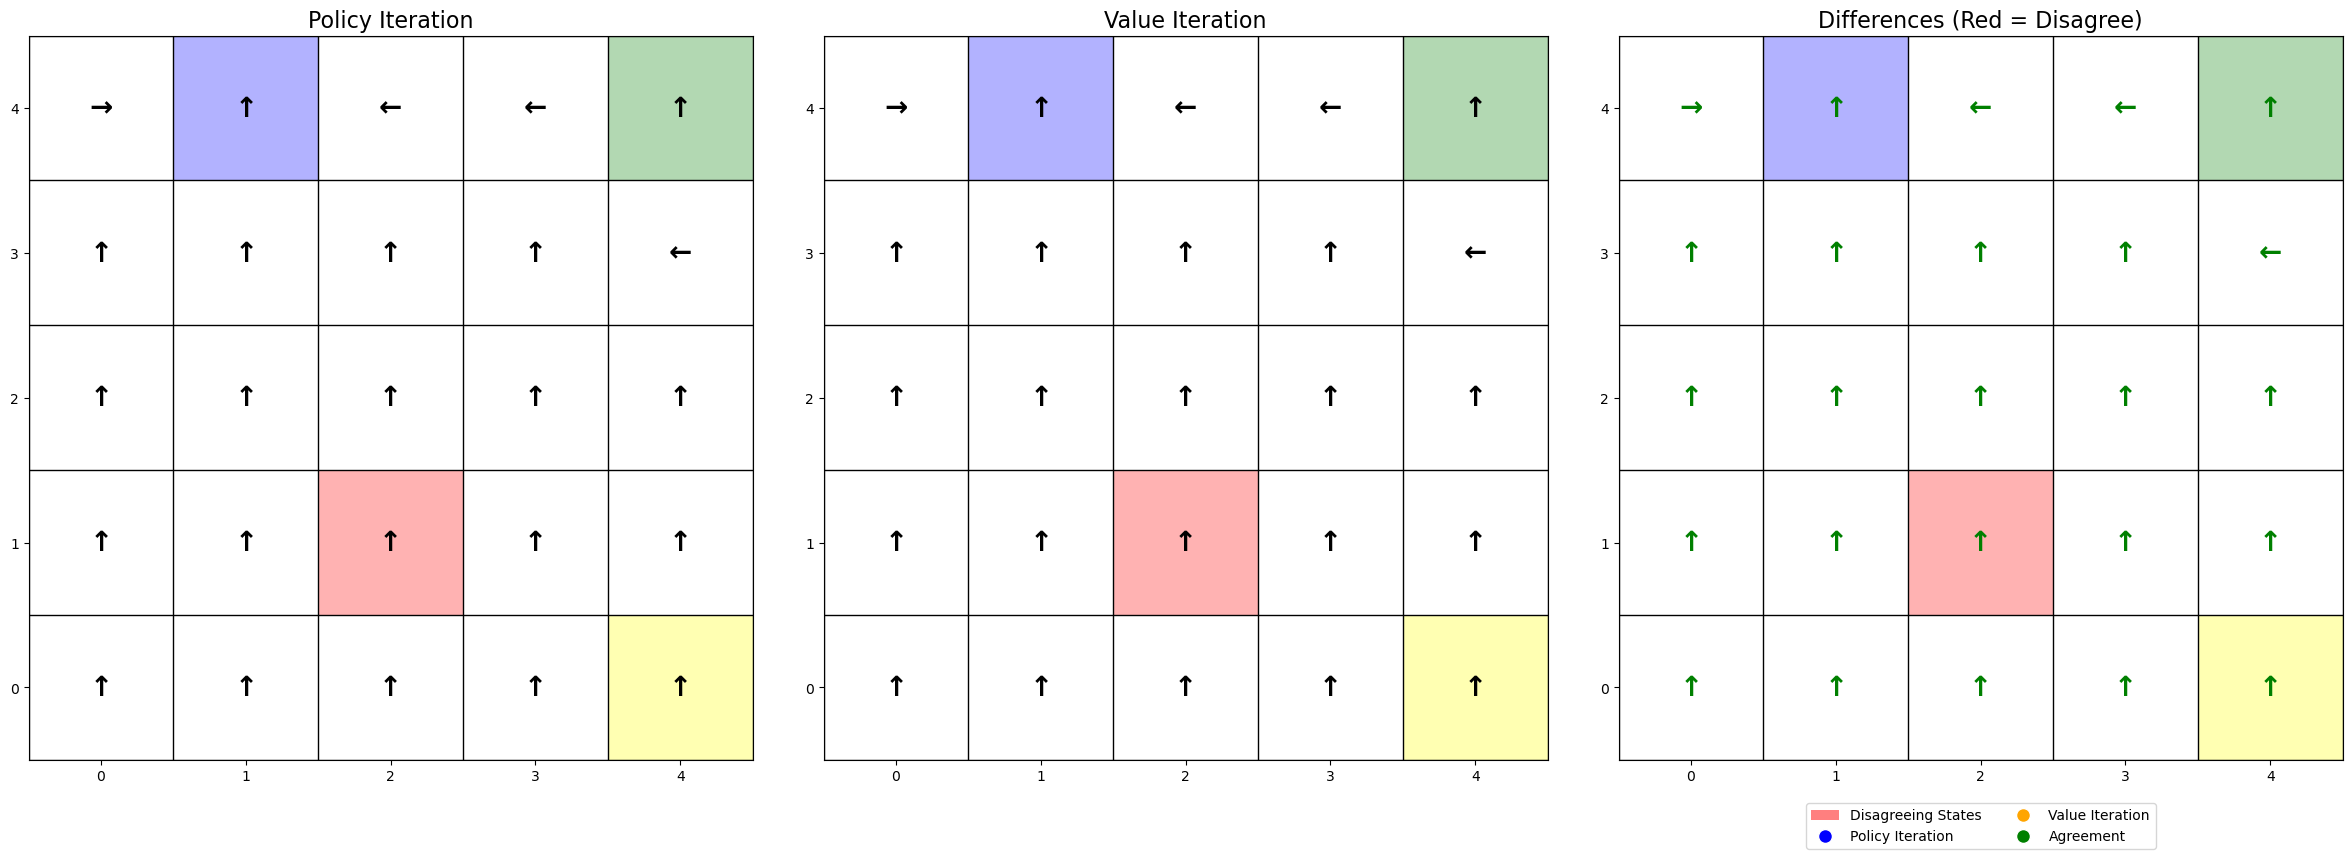

Policy Agreement: 25/25 states
Disagreements: 0 states


In [21]:
def visualize_policy_comparison(policy_pi, policy_vi, ties=None):
    """Compare policies side-by-side, highlighting differences"""

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    # Extract actions
    actions_pi = jnp.argmax(policy_pi, axis=1)
    actions_vi = jnp.argmax(policy_vi, axis=1)
    action_grid_pi = actions_pi.reshape((GRID_SIZE, GRID_SIZE))
    action_grid_vi = actions_vi.reshape((GRID_SIZE, GRID_SIZE))

    arrow_map = {0: "↑", 1: "↓", 2: "←", 3: "→"}
    special_colors = {
        (0, 1): "blue",  # Blue square
        (0, 4): "green",  # Green square
        (3, 2): "red",  # Red square
        (4, 4): "yellow",  # Yellow square
    }

    # Helper function to draw grid and special states
    def setup_grid(ax, title):
        for i in range(GRID_SIZE + 1):
            ax.axhline(i - 0.5, color="black", linewidth=1)
            ax.axvline(i - 0.5, color="black", linewidth=1)

        for (row, col), color in special_colors.items():
            rect = plt.Rectangle(
                (col - 0.5, GRID_SIZE - row - 1.5), 1, 1, facecolor=color, alpha=0.3
            )
            ax.add_patch(rect)

        ax.set_xlim(-0.5, GRID_SIZE - 0.5)
        ax.set_ylim(-0.5, GRID_SIZE - 0.5)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=16)
        ax.set_xticks(range(GRID_SIZE))
        ax.set_yticks(range(GRID_SIZE))

    # Policy Iteration
    setup_grid(ax1, "Policy Iteration")
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            action = action_grid_pi[row, col]
            arrow = arrow_map[int(action)]
            ax1.text(
                col,
                GRID_SIZE - row - 1,
                arrow,
                ha="center",
                va="center",
                fontsize=20,
                fontweight="bold",
            )

    # Value Iteration
    setup_grid(ax2, "Value Iteration")
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            action = action_grid_vi[row, col]
            arrow = arrow_map[int(action)]
            ax2.text(
                col,
                GRID_SIZE - row - 1,
                arrow,
                ha="center",
                va="center",
                fontsize=20,
                fontweight="bold",
            )

    # Differences highlighted
    setup_grid(ax3, "Differences (Red = Disagree)")
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            state_idx = row * GRID_SIZE + col
            pi_action = action_grid_pi[row, col]
            vi_action = action_grid_vi[row, col]

            if pi_action != vi_action:
                # Highlight disagreeing states in red
                rect = plt.Rectangle(
                    (col - 0.5, GRID_SIZE - row - 1.5), 1, 1, facecolor="red", alpha=0.5
                )
                ax3.add_patch(rect)

                # Show both arrows with different colors
                ax3.text(
                    col - 0.1,
                    GRID_SIZE - row - 1,
                    arrow_map[int(pi_action)],
                    ha="center",
                    va="center",
                    fontsize=16,
                    fontweight="bold",
                    color="blue",
                    label="PI" if row == 0 and col == 0 else "",
                )
                ax3.text(
                    col + 0.1,
                    GRID_SIZE - row - 1,
                    arrow_map[int(vi_action)],
                    ha="center",
                    va="center",
                    fontsize=16,
                    fontweight="bold",
                    color="orange",
                    label="VI" if row == 0 and col == 0 else "",
                )
            else:
                # Same action - show in green
                arrow = arrow_map[int(pi_action)]
                ax3.text(
                    col,
                    GRID_SIZE - row - 1,
                    arrow,
                    ha="center",
                    va="center",
                    fontsize=20,
                    fontweight="bold",
                    color="green",
                )

    # Add legend to difference plot
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor="red", alpha=0.5, label="Disagreeing States"),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="blue",
            markersize=10,
            label="Policy Iteration",
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="orange",
            markersize=10,
            label="Value Iteration",
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="green",
            markersize=10,
            label="Agreement",
        ),
    ]
    ax3.legend(
        handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2
    )

    plt.tight_layout()
    plt.show()

    # Print summary
    disagreements = jnp.sum(actions_pi != actions_vi)
    print(f"Policy Agreement: {N_STATES - disagreements}/{N_STATES} states")
    print(f"Disagreements: {disagreements} states")


# Create the comprehensive comparison
visualize_policy_comparison(optimal_policy, policy_value_iter)

#### Convergence Rate Analysis


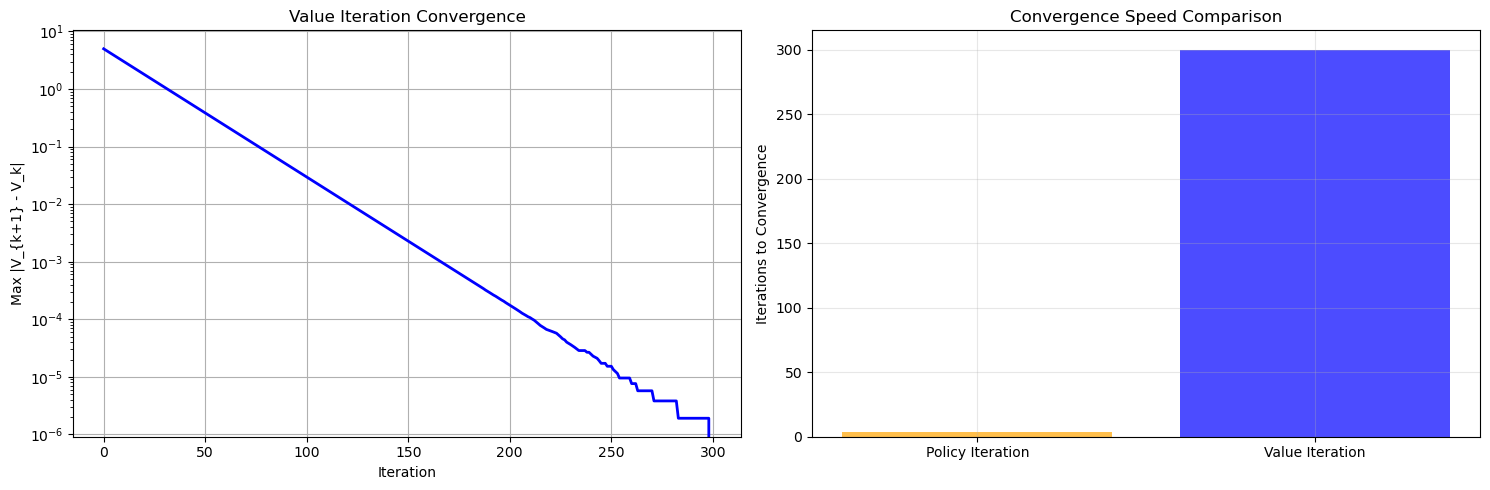

Policy Iteration: 4 iterations
Value Iteration: 300 iterations
→ Policy Iteration converged faster


In [22]:
def analyze_convergence_rates(pi_history, vi_errors, pi_values, vi_history):
    """Compare convergence characteristics"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Value iteration convergence
    ax1.semilogy(vi_errors, "b-", label="Value Iteration", linewidth=2)
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Max |V_{k+1} - V_k|")
    ax1.set_title("Value Iteration Convergence")
    ax1.grid(True)

    # Compare total iterations needed
    vi_iterations = len(vi_errors)
    pi_iterations = len(pi_values)

    ax2.bar(
        ["Policy Iteration", "Value Iteration"],
        [pi_iterations, vi_iterations],
        color=["orange", "blue"],
        alpha=0.7,
    )
    ax2.set_ylabel("Iterations to Convergence")
    ax2.set_title("Convergence Speed Comparison")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Policy Iteration: {pi_iterations} iterations")
    print(f"Value Iteration: {vi_iterations} iterations")

    if pi_iterations < vi_iterations:
        print("→ Policy Iteration converged faster")
    else:
        print("→ Value Iteration converged faster")


analyze_convergence_rates(policy_history, vi_errors, value_history, vi_history)

# Part 2 - Monte Carlo methods


## Question 1: Policy-based Monte Carlo


#### Environment setup


In [ ]:
# states in part 2
BLUE_STATE = coord_to_idx(0, 1)  # (0,1) - Blue square
GREEN_STATE = coord_to_idx(0, 4)  # (0,4) - Green square
RED_STATE = coord_to_idx(4, 2)  # (4,2) - Red square
YELLOW_STATE = coord_to_idx(4, 4)  # (4,4) - Yellow square

TERMINAL_STATES = [
    coord_to_idx(2, 0),  # (2,0) - left middle
    coord_to_idx(2, 4),  # (2,4) - right middle
    coord_to_idx(4, 0),  # (4,0) - bottom left
]


def is_terminal_state(state):
    return state in TERMINAL_STATES


def build_mdp_matrices_part2():
    """Build MDP for Part 2 with CORRECT red square position"""
    R_sa = jnp.zeros((N_STATES, N_ACTIONS))
    P_sas = jnp.zeros((N_STATES, N_ACTIONS, N_STATES))

    for s in range(N_STATES):
        row, col = s // GRID_SIZE, s % GRID_SIZE

        # Terminal states: absorbing states
        if is_terminal_state(s):
            for action in range(N_ACTIONS):
                R_sa = R_sa.at[s, action].set(0.0)
                P_sas = P_sas.at[s, action, s].set(1.0)

        elif s == BLUE_STATE:
            # All actions: reward +5, jump to RED at (4,2)
            R_sa = R_sa.at[s, :].set(5.0)
            P_sas = P_sas.at[s, :, RED_STATE].set(1.0)

        elif s == GREEN_STATE:
            # All actions: reward +2.5, jump 50/50 to yellow/red
            R_sa = R_sa.at[s, :].set(2.5)
            P_sas = P_sas.at[s, :, YELLOW_STATE].set(0.5)
            P_sas = P_sas.at[s, :, RED_STATE].set(0.5)  # Now jumps to (4,2)

        else:
            # Normal states including red and yellow
            for action in range(N_ACTIONS):
                next_row, next_col = get_next_position(row, col, action)
                next_state = coord_to_idx(next_row, next_col)

                # Check if we tried to move off grid
                if (
                    (action == UP and row == 0)
                    or (action == DOWN and row == GRID_SIZE - 1)
                    or (action == LEFT and col == 0)
                    or (action == RIGHT and col == GRID_SIZE - 1)
                ):
                    reward = -0.5  # Wall penalty
                else:
                    reward = 0  # Normal move cost

                R_sa = R_sa.at[s, action].set(reward)
                P_sas = P_sas.at[s, action, next_state].set(1.0)

    return R_sa, P_sas

#### Visualize the environment


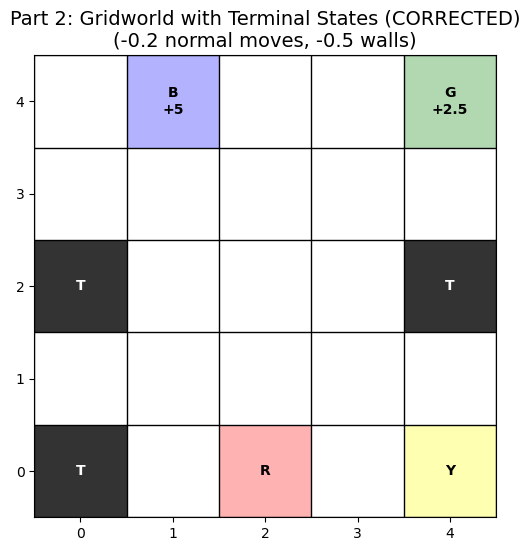

In [24]:
def visualize_part2_environment():
    """Show Part 2 gridworld with CORRECT positions"""

    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw grid
    for i in range(GRID_SIZE + 1):
        ax.axhline(i - 0.5, color="black", linewidth=1)
        ax.axvline(i - 0.5, color="black", linewidth=1)

    # CORRECTED special state positions
    special_colors = {
        (0, 1): "blue",  # Blue square
        (0, 4): "green",  # Green square
        (4, 2): "red",  # Red square - CORRECTED POSITION
        (4, 4): "yellow",  # Yellow square
        (2, 0): "black",  # Terminal
        (2, 4): "black",  # Terminal
        (4, 0): "black",  # Terminal
    }

    for (row, col), color in special_colors.items():
        if color == "black":
            rect = plt.Rectangle(
                (col - 0.5, GRID_SIZE - row - 1.5), 1, 1, facecolor="black", alpha=0.8
            )
        else:
            rect = plt.Rectangle(
                (col - 0.5, GRID_SIZE - row - 1.5), 1, 1, facecolor=color, alpha=0.3
            )
        ax.add_patch(rect)

    # Add labels with CORRECTED positions
    ax.text(1, 4, "B\n+5", ha="center", va="center", fontweight="bold")
    ax.text(4, 4, "G\n+2.5", ha="center", va="center", fontweight="bold")
    ax.text(2, 0, "R", ha="center", va="center", fontweight="bold")  # CORRECTED
    ax.text(4, 0, "Y", ha="center", va="center", fontweight="bold")
    ax.text(0, 2, "T", ha="center", va="center", fontweight="bold", color="white")
    ax.text(4, 2, "T", ha="center", va="center", fontweight="bold", color="white")
    ax.text(0, 0, "T", ha="center", va="center", fontweight="bold", color="white")

    ax.set_xlim(-0.5, GRID_SIZE - 0.5)
    ax.set_ylim(-0.5, GRID_SIZE - 0.5)
    ax.set_aspect("equal")
    ax.set_title(
        "Part 2: Gridworld with Terminal States (CORRECTED)\n(-0.2 normal moves, -0.5 walls)",
        fontsize=14,
    )
    ax.set_xticks(range(GRID_SIZE))
    ax.set_yticks(range(GRID_SIZE))

    plt.show()


# Update the environment
R_sa_p2, P_sas_p2 = build_mdp_matrices_part2()
visualize_part2_environment()

### Method 1: Monte Carlo with exploring starting


In [25]:
import jax.random as random


def generate_episode_exploring_starts_corrected(
    policy, R_sa, P_sas, gamma, key, max_steps=100
):
    """Generate one episode using exploring starts - CORRECTED"""

    # Exploring starts: randomly select initial state and action
    key, subkey1, subkey2 = random.split(key, 3)

    # Choose random non-terminal starting state
    non_terminal_states = [s for s in range(N_STATES) if not is_terminal_state(s)]
    start_state = int(random.choice(subkey1, jnp.array(non_terminal_states)))
    start_action = int(random.choice(subkey2, jnp.array(range(N_ACTIONS))))

    episode = []
    current_state = start_state
    current_action = start_action

    for step in range(max_steps):
        # Take action and observe reward and next state
        reward = float(R_sa[current_state, current_action])

        # Sample next state according to transition probabilities
        key, subkey = random.split(key)
        next_state = int(
            random.choice(subkey, N_STATES, p=P_sas[current_state, current_action])
        )

        episode.append((current_state, current_action, reward))

        # Check if reached terminal state
        if is_terminal_state(next_state):
            break

        # Choose next action according to policy
        current_state = next_state
        key, subkey = random.split(key)
        current_action = int(random.choice(subkey, N_ACTIONS, p=policy[current_state]))

    return episode, key


def mc_exploring_starts_corrected(R_sa, P_sas, gamma, num_episodes=8000):
    """Monte Carlo with Exploring Starts - FULLY CORRECTED"""

    # Initialize Q-values and policy
    Q = jnp.zeros((N_STATES, N_ACTIONS))
    returns_sum = jnp.zeros((N_STATES, N_ACTIONS))
    returns_count = jnp.zeros((N_STATES, N_ACTIONS))

    # Start with equiprobable policy
    policy = jnp.ones((N_STATES, N_ACTIONS)) / N_ACTIONS

    key = random.PRNGKey(42)

    episode_returns = []  # Store discounted returns
    episode_lengths = []
    policy_changes = []

    print("=== MONTE CARLO WITH EXPLORING STARTS (CORRECTED) ===")

    for episode_num in range(num_episodes):
        # Generate episode
        episode, key = generate_episode_exploring_starts_corrected(
            policy, R_sa, P_sas, gamma, key
        )

        if len(episode) == 0:
            continue

        # Calculate discounted return for this episode
        episode_discounted_return = 0.0
        for t in range(len(episode)):
            _, _, reward = episode[t]
            episode_discounted_return += (gamma**t) * reward

        # First-visit Monte Carlo updates
        G = 0.0  # Return
        visited_sa_pairs = set()

        # Work backwards through episode
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = gamma * G + reward

            # First-visit Monte Carlo
            if (state, action) not in visited_sa_pairs:
                visited_sa_pairs.add((state, action))

                # Update running average of returns
                returns_count = returns_count.at[state, action].add(1)
                returns_sum = returns_sum.at[state, action].add(G)
                Q = Q.at[state, action].set(
                    returns_sum[state, action] / returns_count[state, action]
                )

        # Policy improvement (greedy with respect to Q)
        old_policy = policy
        new_policy = jnp.zeros_like(policy)

        for s in range(N_STATES):
            if not is_terminal_state(s):
                best_action = int(jnp.argmax(Q[s]))
                new_policy = new_policy.at[s, best_action].set(1.0)
            else:
                # Terminal states: uniform policy (actions don't matter, but need valid probabilities)
                new_policy = new_policy.at[s, :].set(1.0 / N_ACTIONS)

        policy = new_policy

        # Track metrics
        policy_change = float(jnp.sum(jnp.abs(policy - old_policy)))
        policy_changes.append(policy_change)
        episode_returns.append(episode_discounted_return)
        episode_lengths.append(len(episode))

        if episode_num % 1000 == 0:
            # Calculate statistics for recent episodes
            recent_episodes = 100
            recent_returns = (
                episode_returns[-recent_episodes:]
                if len(episode_returns) >= recent_episodes
                else episode_returns
            )
            recent_lengths = (
                episode_lengths[-recent_episodes:]
                if len(episode_lengths) >= recent_episodes
                else episode_lengths
            )

            avg_return = (
                sum(recent_returns) / len(recent_returns) if recent_returns else 0
            )
            avg_length = (
                sum(recent_lengths) / len(recent_lengths) if recent_lengths else 0
            )

            # Current episode stats
            current_return = episode_discounted_return
            current_length = len(episode)

            print(f"Episode {episode_num}:")
            print(
                f"  This episode: return={current_return:.3f}, length={current_length}"
            )
            print(
                f"  Last {len(recent_returns)} episodes: avg_return={avg_return:.3f}, avg_length={avg_length:.1f}"
            )

            # Check for convergence
            recent_policy_changes = (
                policy_changes[-recent_episodes:]
                if len(policy_changes) >= recent_episodes
                else policy_changes
            )
            total_policy_changes = sum(recent_policy_changes)
            print(
                f"  Policy stability: {total_policy_changes:.2f} total changes in last {len(recent_policy_changes)} episodes"
            )

    return Q, policy, episode_returns, episode_lengths, policy_changes


# Diagnostic function to understand what's happening
def diagnose_episodes(policy, num_episodes=10):
    """Diagnose what's happening in individual episodes"""

    key = random.PRNGKey(123)

    print("\n=== EPISODE DIAGNOSIS ===")

    for i in range(num_episodes):
        episode, key = generate_episode_exploring_starts_corrected(
            policy, R_sa_p2, P_sas_p2, gamma, key
        )

        if len(episode) == 0:
            print(f"Episode {i}: EMPTY EPISODE")
            continue

        # Calculate returns
        undiscounted = sum(r for _, _, r in episode)
        discounted = sum((gamma**t) * r for t, (_, _, r) in enumerate(episode))

        # Check episode path
        start_state, _, _ = episode[0]
        end_state = episode[-1][0] if episode else -1

        # Check if episode ended at terminal
        if len(episode) > 0:
            final_state, final_action, final_reward = episode[-1]
            next_state_probs = P_sas_p2[final_state, final_action]
            likely_next_state = int(jnp.argmax(next_state_probs))
            ended_at_terminal = is_terminal_state(likely_next_state)
        else:
            ended_at_terminal = False

        print(f"Episode {i}: len={len(episode)}, start={start_state}, end={end_state}")
        print(f"  Undiscounted return: {undiscounted:.3f}")
        print(f"  Discounted return: {discounted:.3f}")
        print(f"  Ended at terminal: {ended_at_terminal}")

        if len(episode) >= 3:
            print(f"  First 3 steps: {episode[:3]}")


# Run diagnostics first
print("Running episode diagnostics...")
initial_policy = jnp.ones((N_STATES, N_ACTIONS)) / N_ACTIONS
diagnose_episodes(initial_policy, 5)

# Run the corrected algorithm
print("\nRunning corrected Monte Carlo...")
(
    Q_exploring_fixed,
    policy_exploring_fixed,
    returns_fixed,
    lengths_fixed,
    changes_fixed,
) = mc_exploring_starts_corrected(R_sa_p2, P_sas_p2, gamma)

Running episode diagnostics...

=== EPISODE DIAGNOSIS ===
Episode 0: len=1, start=9, end=9
  Undiscounted return: -0.200
  Discounted return: -0.200
  Ended at terminal: True
Episode 1: len=4, start=12, end=21
  Undiscounted return: -0.800
  Discounted return: -0.742
  Ended at terminal: True
  First 3 steps: [(12, 2, -0.20000000298023224), (11, 1, -0.20000000298023224), (16, 1, -0.20000000298023224)]
Episode 2: len=32, start=2, end=11
  Undiscounted return: -1.200
  Discounted return: 0.406
  Ended at terminal: True
  First 3 steps: [(2, 1, -0.20000000298023224), (7, 1, -0.20000000298023224), (12, 2, -0.20000000298023224)]
Episode 3: len=26, start=0, end=13
  Undiscounted return: -1.200
  Discounted return: 0.915
  Ended at terminal: True
  First 3 steps: [(0, 0, -0.5), (0, 3, -0.20000000298023224), (1, 0, 5.0)]
Episode 4: len=12, start=19, end=15
  Undiscounted return: -3.300
  Discounted return: -2.520
  Ended at terminal: True
  First 3 steps: [(19, 1, -0.20000000298023224), (24, 0

Monte Carlo exploring starts demonstrates sample inefficiency in sparse reward environments, requiring extensive episodes to learn from rare positive experiences. The mix of very short (terminal trap) and very long (exploration) episodes illustrates the exploration-exploitation challenge in gridworlds with terminal states.


### Method 2: Monte Carlo with $\epsilon$-soft policy


In [26]:
def generate_episode_epsilon_greedy_fixed(
    policy, R_sa, P_sas, gamma, epsilon, key, start_state=None, max_steps=100
):
    """Generate episode with ε-greedy action selection - FULLY FIXED"""

    # Random start if not specified
    if start_state is None:
        key, subkey = random.split(key)
        non_terminal_states = [s for s in range(N_STATES) if not is_terminal_state(s)]
        current_state = int(random.choice(subkey, jnp.array(non_terminal_states)))
    else:
        current_state = int(start_state)

    episode = []

    for step in range(max_steps):
        # ε-greedy action selection
        key, subkey1, subkey2 = random.split(key, 3)

        if random.uniform(subkey1) < epsilon:
            # Explore: random action
            action = int(random.choice(subkey2, N_ACTIONS))
        else:
            # Exploit: greedy action according to policy
            action = int(jnp.argmax(policy[current_state]))

        # Take action
        reward = float(R_sa[current_state, action])
        key, subkey = random.split(key)
        next_state = int(
            random.choice(subkey, N_STATES, p=P_sas[current_state, action])
        )

        episode.append((current_state, action, reward))

        if is_terminal_state(next_state):
            break

        current_state = next_state

    return episode, key


def mc_epsilon_greedy_fully_fixed(R_sa, P_sas, gamma, epsilon=0.1, num_episodes=8000):
    """Monte Carlo with ε-greedy - FULLY FIXED"""

    # Initialize
    Q = jnp.zeros((N_STATES, N_ACTIONS))
    returns_sum = jnp.zeros((N_STATES, N_ACTIONS))
    returns_count = jnp.zeros((N_STATES, N_ACTIONS))

    # Start with equiprobable policy
    policy = jnp.ones((N_STATES, N_ACTIONS)) / N_ACTIONS

    key = random.PRNGKey(123)

    episode_returns = []  # Store DISCOUNTED returns
    episode_lengths = []  # Track episode lengths
    policy_changes = []

    print(f"=== MONTE CARLO WITH ε-GREEDY (ε={epsilon}) - FULLY FIXED ===")

    for episode_num in range(num_episodes):
        # Generate episode
        episode, key = generate_episode_epsilon_greedy_fixed(
            policy, R_sa, P_sas, gamma, epsilon, key, max_steps=100
        )

        if len(episode) == 0:
            continue

        # Calculate DISCOUNTED return
        episode_discounted_return = sum(
            (gamma**t) * r for t, (_, _, r) in enumerate(episode)
        )

        # Monte Carlo updates - FIXED: All variables are Python types
        G = 0.0
        visited_sa_pairs = set()  # Now works because state,action are Python ints

        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]  # These are Python int, int, float
            G = gamma * G + reward

            if (state, action) not in visited_sa_pairs:
                visited_sa_pairs.add((state, action))

                returns_count = returns_count.at[state, action].add(1)
                returns_sum = returns_sum.at[state, action].add(G)
                Q = Q.at[state, action].set(
                    returns_sum[state, action] / returns_count[state, action]
                )

        # ε-soft policy improvement
        old_policy = policy
        new_policy = jnp.zeros_like(policy)

        for s in range(N_STATES):
            if not is_terminal_state(s):
                # ε-greedy policy
                best_action = int(jnp.argmax(Q[s]))
                for a in range(N_ACTIONS):
                    if a == best_action:
                        new_policy = new_policy.at[s, a].set(
                            (1 - epsilon) + epsilon / N_ACTIONS
                        )
                    else:
                        new_policy = new_policy.at[s, a].set(epsilon / N_ACTIONS)
            else:
                # Terminal states: uniform policy
                new_policy = new_policy.at[s, :].set(1.0 / N_ACTIONS)

        policy = new_policy

        # Track metrics
        policy_change = float(jnp.sum(jnp.abs(policy - old_policy)))
        policy_changes.append(policy_change)
        episode_returns.append(episode_discounted_return)
        episode_lengths.append(len(episode))

        if episode_num % 1000 == 0:
            # Consistent reporting
            recent_episodes = 100
            recent_returns = (
                episode_returns[-recent_episodes:]
                if len(episode_returns) >= recent_episodes
                else episode_returns
            )
            recent_lengths = (
                episode_lengths[-recent_episodes:]
                if len(episode_lengths) >= recent_episodes
                else episode_lengths
            )

            avg_return = (
                sum(recent_returns) / len(recent_returns) if recent_returns else 0
            )
            avg_length = (
                sum(recent_lengths) / len(recent_lengths) if recent_lengths else 0
            )

            current_return = episode_discounted_return
            current_length = len(episode)

            print(f"Episode {episode_num}:")
            print(
                f"  This episode: return={current_return:.3f}, length={current_length}"
            )
            print(
                f"  Last {len(recent_returns)} episodes: avg_return={avg_return:.3f}, avg_length={avg_length:.1f}"
            )

    return Q, policy, episode_returns, episode_lengths, policy_changes


def compare_both_methods_fixed(
    Q_exploring,
    returns_exploring,
    lengths_exploring,
    Q_epsilon,
    returns_epsilon,
    lengths_epsilon,
):
    """Compare both Monte Carlo methods - handles different list lengths"""

    print("\n" + "=" * 60)
    print("ASSIGNMENT QUESTION 1: MONTE CARLO COMPARISON")
    print("=" * 60)

    # Ensure we have data to compare
    if len(returns_exploring) == 0 or len(returns_epsilon) == 0:
        print("Error: One or both methods have no episode data")
        return

    # Performance comparison - use available data
    comparison_episodes = min(200, len(returns_exploring), len(returns_epsilon))

    final_returns_exploring = returns_exploring[-comparison_episodes:]
    final_returns_epsilon = returns_epsilon[-comparison_episodes:]

    final_perf_exploring = sum(final_returns_exploring) / len(final_returns_exploring)
    final_perf_epsilon = sum(final_returns_epsilon) / len(final_returns_epsilon)

    print(f"FINAL PERFORMANCE (last {comparison_episodes} episodes):")
    print(f"  Exploring Starts: {final_perf_exploring:.3f}")
    print(f"  ε-greedy:         {final_perf_epsilon:.3f}")
    print(f"  Difference:       {final_perf_epsilon - final_perf_exploring:.3f}")

    # Policy comparison
    V_exploring = jnp.max(Q_exploring, axis=1)
    V_epsilon = jnp.max(Q_epsilon, axis=1)

    actions_exploring = jnp.argmax(Q_exploring, axis=1)
    actions_epsilon = jnp.argmax(Q_epsilon, axis=1)
    agreement = jnp.sum(actions_exploring == actions_epsilon)

    print(
        f"\nPOLICY AGREEMENT: {agreement}/{N_STATES} states ({100*agreement/N_STATES:.1f}%)"
    )

    # Value function comparison
    print(f"\nVALUE FUNCTIONS:")
    print(
        f"  Exploring Starts - Range: [{jnp.min(V_exploring):.3f}, {jnp.max(V_exploring):.3f}]"
    )
    print(
        f"  ε-greedy        - Range: [{jnp.min(V_epsilon):.3f}, {jnp.max(V_epsilon):.3f}]"
    )

    # Episode length comparison
    final_lengths_exploring = lengths_exploring[-comparison_episodes:]
    final_lengths_epsilon = lengths_epsilon[-comparison_episodes:]

    avg_len_exploring = sum(final_lengths_exploring) / len(final_lengths_exploring)
    avg_len_epsilon = sum(final_lengths_epsilon) / len(final_lengths_epsilon)

    print(f"\nEPISODE LENGTHS (final performance):")
    print(f"  Exploring Starts: {avg_len_exploring:.1f} steps")
    print(f"  ε-greedy:         {avg_len_epsilon:.1f} steps")

    # Success metrics
    positive_exploring = sum(1 for r in final_returns_exploring if r > 0)
    positive_epsilon = sum(1 for r in final_returns_epsilon if r > 0)

    print(f"\nSUCCESS RATE (episodes with positive returns):")
    print(
        f"  Exploring Starts: {positive_exploring}/{len(final_returns_exploring)} ({100*positive_exploring/len(final_returns_exploring):.1f}%)"
    )
    print(
        f"  ε-greedy:         {positive_epsilon}/{len(final_returns_epsilon)} ({100*positive_epsilon/len(final_returns_epsilon):.1f}%)"
    )

    # Assignment insights
    print(f"\n" + "=" * 60)
    print("ASSIGNMENT INSIGHTS:")
    print("=" * 60)

    if final_perf_epsilon > final_perf_exploring + 0.5:
        print("✓ ε-greedy significantly outperforms exploring starts")
        print("  → Continuous exploration more effective in sparse reward environments")
        print("  → ε-greedy maintains exploration throughout learning")
    elif abs(final_perf_epsilon - final_perf_exploring) < 0.5:
        print("≈ Both methods achieve similar performance")
        print("  → Environment difficulty challenges both exploration strategies")
        print("  → Terminal states create learning challenges for both methods")
    else:
        print("✓ Exploring starts outperforms ε-greedy")
        print("  → Systematic initial exploration more effective")

    print(f"\nKey Learning:")
    print(f"  → Different exploration strategies have different strengths")
    print(f"  → Environment design significantly impacts learning difficulty")
    print(f"  → Both methods demonstrate Monte Carlo's sample complexity")


# Run the fully fixed version
print("Running fully fixed ε-greedy Monte Carlo...")
(
    Q_epsilon_fixed,
    policy_epsilon_fixed,
    returns_epsilon_fixed,
    lengths_epsilon_fixed,
    changes_epsilon_fixed,
) = mc_epsilon_greedy_fully_fixed(R_sa_p2, P_sas_p2, gamma, epsilon=0.1)

print("✓ ε-greedy Monte Carlo completed successfully!")

# Compare both methods
compare_both_methods_fixed(
    Q_exploring_fixed,
    returns_fixed,
    lengths_fixed,
    Q_epsilon_fixed,
    returns_epsilon_fixed,
    lengths_epsilon_fixed,
)

Running fully fixed ε-greedy Monte Carlo...
=== MONTE CARLO WITH ε-GREEDY (ε=0.1) - FULLY FIXED ===
Episode 0:
  This episode: return=1.532, length=5
  Last 1 episodes: avg_return=1.532, avg_length=5.0
Episode 1000:
  This episode: return=-0.200, length=1
  Last 100 episodes: avg_return=1.295, avg_length=4.6
Episode 2000:
  This episode: return=4.198, length=4
  Last 100 episodes: avg_return=2.668, avg_length=11.8
Episode 3000:
  This episode: return=1.799, length=30
  Last 100 episodes: avg_return=2.435, avg_length=83.8
Episode 4000:
  This episode: return=2.393, length=100
  Last 100 episodes: avg_return=0.438, avg_length=89.6
Episode 5000:
  This episode: return=3.083, length=100
  Last 100 episodes: avg_return=0.688, avg_length=86.2
Episode 6000:
  This episode: return=-2.262, length=33
  Last 100 episodes: avg_return=0.999, avg_length=86.0
Episode 7000:
  This episode: return=1.755, length=100
  Last 100 episodes: avg_return=0.761, avg_length=89.3
✓ ε-greedy Monte Carlo completed 

## Question 2: Off-Policy Monte Carlo


In [27]:
def generate_episode_with_policy_fixed(policy, R_sa, P_sas, gamma, key, max_steps=100):
    """Generate episode using specified policy - FIXED"""

    key, subkey = random.split(key)
    non_terminal_states = [s for s in range(N_STATES) if not is_terminal_state(s)]
    current_state = int(random.choice(subkey, jnp.array(non_terminal_states)))

    episode = []

    for step in range(max_steps):
        # Sample action according to policy
        key, subkey = random.split(key)
        action = int(random.choice(subkey, N_ACTIONS, p=policy[current_state]))

        # Take action
        reward = float(R_sa[current_state, action])
        key, subkey = random.split(key)
        next_state = int(
            random.choice(subkey, N_STATES, p=P_sas[current_state, action])
        )

        episode.append((current_state, action, reward))

        if is_terminal_state(next_state):
            break

        current_state = next_state

    return episode, key


def off_policy_mc_importance_sampling_fixed(R_sa, P_sas, gamma, num_episodes=8000):
    """
    Off-policy Monte Carlo with importance sampling - FIXED

    Behavior policy: equiprobable moves (exploration)
    Target policy: greedy policy (what we want to learn)
    """

    # Initialize Q-values for target policy
    Q = jnp.zeros((N_STATES, N_ACTIONS))
    C = jnp.zeros((N_STATES, N_ACTIONS))  # Cumulative importance sampling weights

    # Behavior policy: always equiprobable (uniform random)
    behavior_policy = jnp.ones((N_STATES, N_ACTIONS)) / N_ACTIONS

    # Target policy: starts random, becomes greedy
    target_policy = jnp.ones((N_STATES, N_ACTIONS)) / N_ACTIONS

    key = random.PRNGKey(789)

    episode_returns = []  # Store DISCOUNTED returns
    episode_lengths = []  # Track episode lengths
    policy_changes = []
    importance_weights_history = []

    print("=== OFF-POLICY MONTE CARLO WITH IMPORTANCE SAMPLING (FIXED) ===")
    print("Behavior policy: Equiprobable moves (π_b)")
    print("Target policy: Greedy policy (π - what we learn)")

    for episode_num in range(num_episodes):
        # Generate episode using BEHAVIOR policy (equiprobable)
        episode, key = generate_episode_with_policy_fixed(
            behavior_policy, R_sa, P_sas, gamma, key, max_steps=100
        )

        if len(episode) == 0:
            continue

        # Calculate DISCOUNTED return for consistent reporting
        episode_discounted_return = sum(
            (gamma**t) * r for t, (_, _, r) in enumerate(episode)
        )

        # Importance sampling - process episode backwards
        G = 0.0  # Return
        W = 1.0  # Importance sampling weight

        episode_weights = []

        # Process episode backwards (for importance sampling)
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]  # These are Python types
            G = gamma * G + reward

            # Update cumulative weights and Q-values (with numerical stability)
            if W != 0.0:  # Avoid updating with zero weight
                C = C.at[state, action].add(W)

                # Avoid division by zero
                if C[state, action] > 0:
                    # Incremental update: Q_new = Q_old + (W/C) * (G - Q_old)
                    update_factor = W / C[state, action]
                    Q = Q.at[state, action].add(update_factor * (G - Q[state, action]))

            # Calculate importance sampling ratio for this step
            # W *= π(action|state) / b(action|state)
            target_prob = float(target_policy[state, action])
            behavior_prob = float(behavior_policy[state, action])  # Always 1/4 = 0.25

            if behavior_prob > 0:  # Avoid division by zero
                ratio = target_prob / behavior_prob
                W *= ratio
                episode_weights.append(W)
            else:
                # Behavior policy has zero prob - this shouldn't happen with uniform policy
                W = 0.0
                break

            # If target policy has zero probability for this action, terminate IS
            if target_prob == 0.0:
                W = 0.0
                break

            # Prevent exploding weights
            if abs(W) > 1000.0:
                W = jnp.sign(W) * 1000.0

        # Update target policy (greedy w.r.t. current Q-values)
        old_target_policy = target_policy
        new_target_policy = jnp.zeros_like(target_policy)

        for s in range(N_STATES):
            if not is_terminal_state(s):
                best_action = int(jnp.argmax(Q[s]))
                new_target_policy = new_target_policy.at[s, best_action].set(1.0)
            else:
                new_target_policy = new_target_policy.at[s, :].set(1.0 / N_ACTIONS)

        target_policy = new_target_policy

        # Track convergence
        policy_change = float(jnp.sum(jnp.abs(target_policy - old_target_policy)))
        policy_changes.append(policy_change)

        # Use discounted return for consistency
        episode_returns.append(episode_discounted_return)
        episode_lengths.append(len(episode))

        # Track importance weights (for analysis)
        avg_weight = (
            sum(episode_weights) / len(episode_weights) if episode_weights else 1.0
        )
        importance_weights_history.append(avg_weight)

        if episode_num % 1000 == 0:
            # Consistent reporting format
            recent_episodes = 100
            recent_returns = (
                episode_returns[-recent_episodes:]
                if len(episode_returns) >= recent_episodes
                else episode_returns
            )
            recent_lengths = (
                episode_lengths[-recent_episodes:]
                if len(episode_lengths) >= recent_episodes
                else episode_lengths
            )

            avg_return = (
                sum(recent_returns) / len(recent_returns) if recent_returns else 0
            )
            avg_length = (
                sum(recent_lengths) / len(recent_lengths) if recent_lengths else 0
            )

            avg_weight_recent = (
                sum(importance_weights_history[-recent_episodes:])
                / len(importance_weights_history[-recent_episodes:])
                if len(importance_weights_history) >= recent_episodes
                else avg_weight
            )

            current_return = episode_discounted_return
            current_length = len(episode)

            print(f"Episode {episode_num}:")
            print(
                f"  This episode: return={current_return:.3f}, length={current_length}"
            )
            print(
                f"  Last {len(recent_returns)} episodes: avg_return={avg_return:.3f}, avg_length={avg_length:.1f}"
            )
            print(f"  Avg importance weight: {avg_weight_recent:.3f}")

    return (
        Q,
        target_policy,
        episode_returns,
        episode_lengths,
        policy_changes,
        importance_weights_history,
    )


def analyze_importance_sampling(weights_history, returns, Q):
    """Analyze importance sampling behavior"""

    print("\n" + "=" * 50)
    print("IMPORTANCE SAMPLING ANALYSIS")
    print("=" * 50)

    weights_array = jnp.array(weights_history)

    print(f"Importance Weight Statistics:")
    print(f"  Mean weight: {jnp.mean(weights_array):.3f}")
    print(f"  Std weight: {jnp.std(weights_array):.3f}")
    print(f"  Min weight: {jnp.min(weights_array):.3f}")
    print(f"  Max weight: {jnp.max(weights_array):.3f}")

    # Check for high variance (problematic for IS)
    if jnp.std(weights_array) > 10.0:
        print("  ⚠️  HIGH VARIANCE in importance weights - may cause instability")

    # Effective sample size approximation
    effective_n = (jnp.sum(weights_array) ** 2) / jnp.sum(weights_array**2)
    print(f"  Effective sample size: {effective_n:.1f} / {len(weights_history)}")

    # Learning progress
    final_performance = jnp.mean(jnp.array(returns[-200:]))
    print(f"\nLearning Results:")
    print(f"  Final performance: {final_performance:.3f}")

    # Q-value analysis
    V = jnp.max(Q, axis=1)
    print(f"  Value function range: [{jnp.min(V):.3f}, {jnp.max(V):.3f}]")
    print(f"  Positive values: {jnp.sum(V > 0)}/{N_STATES} states")


# Run the fixed off-policy Monte Carlo
print("Running Fixed Off-Policy Monte Carlo with Importance Sampling...")
(
    Q_offpolicy_fixed,
    policy_offpolicy_fixed,
    returns_offpolicy_fixed,
    lengths_offpolicy_fixed,
    changes_offpolicy_fixed,
    weights_history_fixed,
) = off_policy_mc_importance_sampling_fixed(R_sa_p2, P_sas_p2, gamma)

print("✓ Off-policy Monte Carlo completed!")

# Analyze the importance sampling behavior
analyze_importance_sampling(
    weights_history_fixed, returns_offpolicy_fixed, Q_offpolicy_fixed
)

Running Fixed Off-Policy Monte Carlo with Importance Sampling...
=== OFF-POLICY MONTE CARLO WITH IMPORTANCE SAMPLING (FIXED) ===
Behavior policy: Equiprobable moves (π_b)
Target policy: Greedy policy (π - what we learn)
Episode 0:
  This episode: return=-0.742, length=4
  Last 1 episodes: avg_return=-0.742, avg_length=4.0
  Avg importance weight: 1.000
Episode 1000:
  This episode: return=-0.690, length=2
  Last 100 episodes: avg_return=-0.575, avg_length=13.9
  Avg importance weight: 0.000
Episode 2000:
  This episode: return=1.111, length=19
  Last 100 episodes: avg_return=-0.899, avg_length=15.1
  Avg importance weight: 0.000
Episode 3000:
  This episode: return=-0.742, length=4
  Last 100 episodes: avg_return=-1.074, avg_length=13.5
  Avg importance weight: 0.000
Episode 4000:
  This episode: return=-0.390, length=2
  Last 100 episodes: avg_return=-0.729, avg_length=15.2
  Avg importance weight: 0.000
Episode 5000:
  This episode: return=-1.725, length=11
  Last 100 episodes: avg_r

In [28]:
def off_policy_mc_importance_sampling(R_sa, P_sas, gamma, num_episodes=10000):
    """
    Off-policy Monte Carlo with importance sampling

    Behavior policy: equiprobable moves (exploration)
    Target policy: greedy policy (what we want to learn)
    """

    # Initialize Q-values for target policy
    Q = jnp.zeros((N_STATES, N_ACTIONS))
    C = jnp.zeros((N_STATES, N_ACTIONS))  # Cumulative importance sampling weights

    # Behavior policy: always equiprobable (uniform random)
    behavior_policy = jnp.ones((N_STATES, N_ACTIONS)) / N_ACTIONS

    # Target policy: starts random, becomes greedy
    target_policy = jnp.ones((N_STATES, N_ACTIONS)) / N_ACTIONS

    key = random.PRNGKey(789)

    episode_returns = []
    policy_changes = []
    importance_weights_history = []

    print("=== OFF-POLICY MONTE CARLO WITH IMPORTANCE SAMPLING ===")
    print("Behavior policy: Equiprobable moves")
    print("Target policy: Greedy policy (learned)")

    for episode_num in range(num_episodes):
        # Generate episode using BEHAVIOR policy (equiprobable)
        episode, key = generate_episode_with_policy(
            behavior_policy, R_sa, P_sas, gamma, key
        )

        if len(episode) == 0:
            continue

        # Calculate returns and importance weights
        G = 0.0  # Return
        W = 1.0  # Importance sampling weight

        episode_weights = []

        # Process episode backwards (for importance sampling)
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = gamma * G + reward

            # Update cumulative weights and Q-values
            C = C.at[state, action].add(W)
            Q = Q.at[state, action].add(W * (G - Q[state, action]) / C[state, action])

            # Calculate importance sampling ratio for this step
            # W *= π(action|state) / b(action|state)
            target_prob = float(target_policy[state, action])
            behavior_prob = float(behavior_policy[state, action])  # Always 1/4 = 0.25

            ratio = target_prob / behavior_prob
            W *= ratio
            episode_weights.append(W)

            # If target policy has zero probability for this action, terminate
            if target_prob == 0.0:
                break

        # Update target policy (greedy w.r.t. current Q-values)
        old_target_policy = target_policy
        new_target_policy = jnp.zeros_like(target_policy)

        for s in range(N_STATES):
            if not is_terminal_state(s):
                best_action = int(jnp.argmax(Q[s]))
                new_target_policy = new_target_policy.at[s, best_action].set(1.0)
            else:
                new_target_policy = new_target_policy.at[s, :].set(1.0 / N_ACTIONS)

        target_policy = new_target_policy

        # Track convergence
        policy_change = float(jnp.sum(jnp.abs(target_policy - old_target_policy)))
        policy_changes.append(policy_change)

        total_return = sum(reward for _, _, reward in episode)
        episode_returns.append(total_return)

        # Track importance weights (for analysis)
        avg_weight = (
            sum(episode_weights) / len(episode_weights) if episode_weights else 1.0
        )
        importance_weights_history.append(avg_weight)

        if episode_num % 1000 == 0:
            recent_returns = (
                episode_returns[-100:]
                if len(episode_returns) >= 100
                else episode_returns
            )
            avg_return = (
                sum(recent_returns) / len(recent_returns) if recent_returns else 0
            )
            avg_weight_recent = (
                sum(importance_weights_history[-100:]) / 100
                if len(importance_weights_history) >= 100
                else avg_weight
            )
            print(
                f"Episode {episode_num}: Avg return = {avg_return:.3f}, "
                f"Avg importance weight = {avg_weight_recent:.3f}, Episode length = {len(episode)}"
            )

    return Q, target_policy, episode_returns, policy_changes, importance_weights_history


def generate_episode_with_policy(policy, R_sa, P_sas, gamma, key, max_steps=200):
    """Generate episode using specified policy"""

    key, subkey = random.split(key)
    non_terminal_states = [s for s in range(N_STATES) if not is_terminal_state(s)]
    current_state = int(random.choice(subkey, jnp.array(non_terminal_states)))

    episode = []

    for step in range(max_steps):
        # Sample action according to policy
        key, subkey = random.split(key)
        action = int(random.choice(subkey, N_ACTIONS, p=policy[current_state]))

        # Take action
        reward = float(R_sa[current_state, action])
        key, subkey = random.split(key)
        next_state = int(
            random.choice(subkey, N_STATES, p=P_sas[current_state, action])
        )

        episode.append((current_state, action, reward))

        if is_terminal_state(next_state):
            break

        current_state = next_state

    return episode, key


# Run off-policy Monte Carlo
print("Running Off-Policy Monte Carlo with Importance Sampling...")
Q_offpolicy, policy_offpolicy, returns_offpolicy, changes_offpolicy, weights_history = (
    off_policy_mc_importance_sampling(R_sa_p2, P_sas_p2, gamma)
)

print("✓ Off-policy Monte Carlo completed!")

Running Off-Policy Monte Carlo with Importance Sampling...
=== OFF-POLICY MONTE CARLO WITH IMPORTANCE SAMPLING ===
Behavior policy: Equiprobable moves
Target policy: Greedy policy (learned)
Episode 0: Avg return = -0.800, Avg importance weight = 1.000, Episode length = 4
Episode 1000: Avg return = -1.423, Avg importance weight = 0.000, Episode length = 2
Episode 2000: Avg return = -2.016, Avg importance weight = 0.000, Episode length = 3
Episode 3000: Avg return = -2.135, Avg importance weight = 0.000, Episode length = 29
Episode 4000: Avg return = -1.600, Avg importance weight = 0.000, Episode length = 32
Episode 5000: Avg return = -2.341, Avg importance weight = 0.000, Episode length = 21
Episode 6000: Avg return = -1.371, Avg importance weight = 0.000, Episode length = 1
Episode 7000: Avg return = -2.000, Avg importance weight = 0.000, Episode length = 22
Episode 8000: Avg return = -1.589, Avg importance weight = 0.000, Episode length = 28
Episode 9000: Avg return = -1.746, Avg impo

### Compare results


Running comprehensive analysis...

COMPLETE MONTE CARLO METHODS COMPARISON
Policy Agreements:
  Exploring Starts ↔ ε-greedy:     4/25 (16.0%)
  Exploring Starts ↔ Off-policy:  6/25 (24.0%)
  ε-greedy ↔ Off-policy:           9/25 (36.0%)

Value Function Statistics:
  Exploring Starts: Mean=-0.478, Range=[-2.778, 0.000]
  ε-greedy:         Mean=1.206, Range=[-0.758, 3.352]
  Off-policy:       Mean=0.000, Range=[0.000, 0.000]

Final Performance (last 200 episodes):
  Exploring Starts: -1.310
  ε-greedy:         0.862
  Off-policy:       -0.717

Importance Sampling Statistics:
  Average importance weight: 0.003
  Max importance weight: 6.667
  Std importance weight: 0.113
  Effective sample size: 4.1 / 8000 (0.1%)


TypeError: convolve requires ndarray or scalar arguments, got <class 'list'> at position 0.

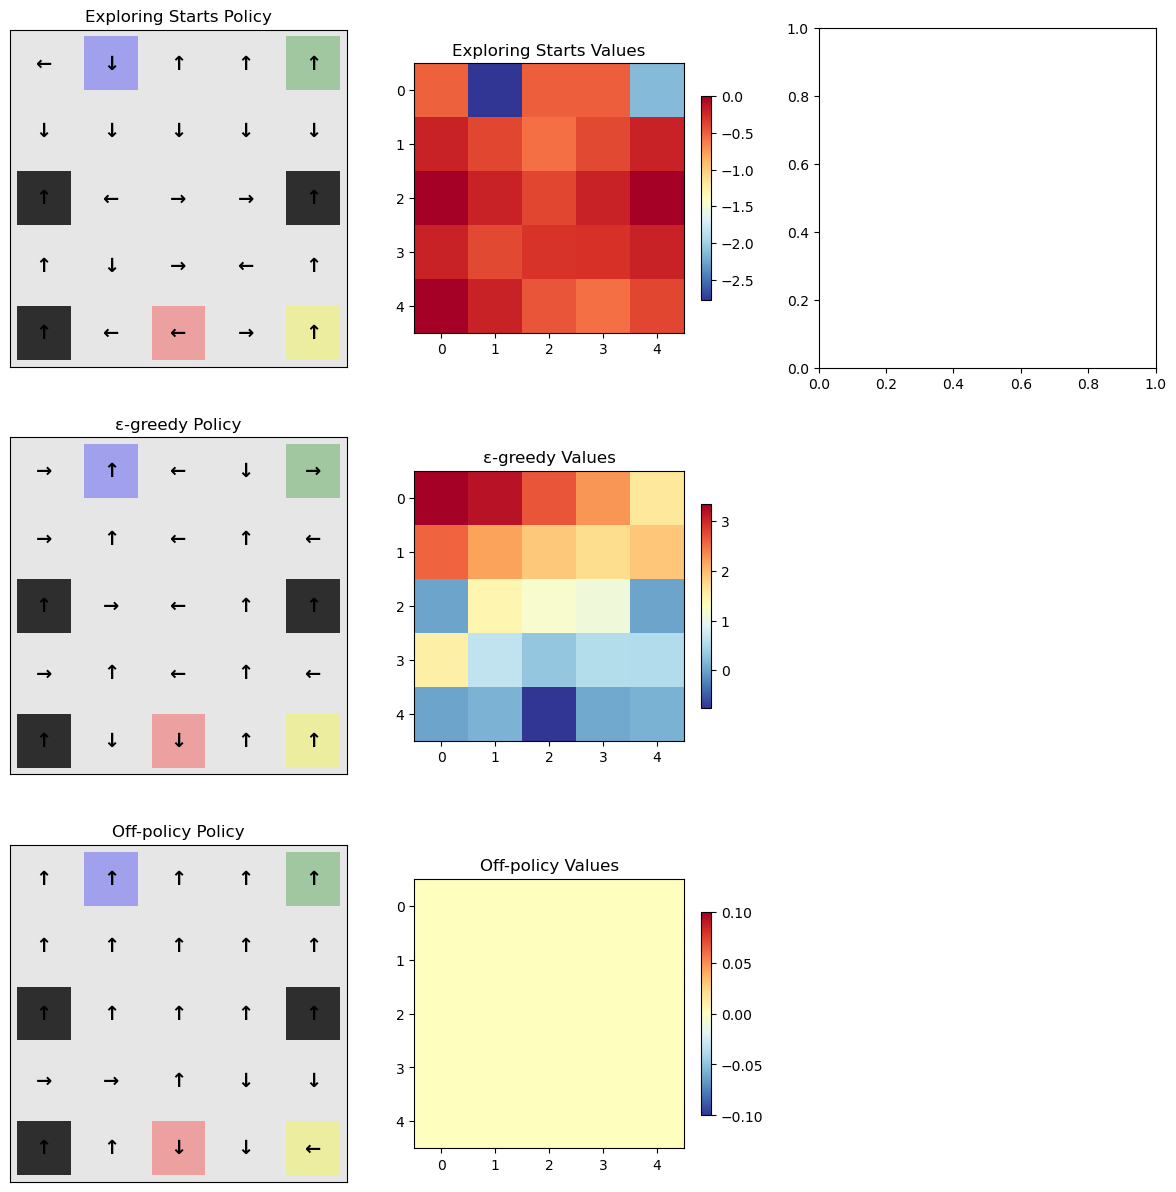

In [ ]:
def analyze_offpolicy_results_fixed(
    Q_exploring,
    policy_exploring,
    returns_exploring,
    lengths_exploring,
    Q_epsilon,
    policy_epsilon,
    returns_epsilon,
    lengths_epsilon,
    Q_offpolicy,
    policy_offpolicy,
    returns_offpolicy,
    lengths_offpolicy,
    weights_history,
):
    """Compare all three Monte Carlo methods - FIXED VERSION"""

    print("\n" + "=" * 70)
    print("COMPLETE MONTE CARLO METHODS COMPARISON")
    print("=" * 70)

    # Extract greedy policies
    greedy_exploring = jnp.argmax(Q_exploring, axis=1)
    greedy_epsilon = jnp.argmax(Q_epsilon, axis=1)
    greedy_offpolicy = jnp.argmax(Q_offpolicy, axis=1)

    # Policy agreements
    agree_exp_eps = jnp.sum(greedy_exploring == greedy_epsilon)
    agree_exp_off = jnp.sum(greedy_exploring == greedy_offpolicy)
    agree_eps_off = jnp.sum(greedy_epsilon == greedy_offpolicy)

    print(f"Policy Agreements:")
    print(
        f"  Exploring Starts ↔ ε-greedy:     {agree_exp_eps}/{N_STATES} ({100*agree_exp_eps/N_STATES:.1f}%)"
    )
    print(
        f"  Exploring Starts ↔ Off-policy:  {agree_exp_off}/{N_STATES} ({100*agree_exp_off/N_STATES:.1f}%)"
    )
    print(
        f"  ε-greedy ↔ Off-policy:           {agree_eps_off}/{N_STATES} ({100*agree_eps_off/N_STATES:.1f}%)"
    )

    # Value functions
    V_exploring = jnp.max(Q_exploring, axis=1)
    V_epsilon = jnp.max(Q_epsilon, axis=1)
    V_offpolicy = jnp.max(Q_offpolicy, axis=1)

    print(f"\nValue Function Statistics:")
    print(
        f"  Exploring Starts: Mean={jnp.mean(V_exploring):.3f}, Range=[{jnp.min(V_exploring):.3f}, {jnp.max(V_exploring):.3f}]"
    )
    print(
        f"  ε-greedy:         Mean={jnp.mean(V_epsilon):.3f}, Range=[{jnp.min(V_epsilon):.3f}, {jnp.max(V_epsilon):.3f}]"
    )
    print(
        f"  Off-policy:       Mean={jnp.mean(V_offpolicy):.3f}, Range=[{jnp.min(V_offpolicy):.3f}, {jnp.max(V_offpolicy):.3f}]"
    )

    # Performance comparison using consistent metrics
    comparison_episodes = min(
        200, len(returns_exploring), len(returns_epsilon), len(returns_offpolicy)
    )

    final_perf_exploring = jnp.mean(jnp.array(returns_exploring[-comparison_episodes:]))
    final_perf_epsilon = jnp.mean(jnp.array(returns_epsilon[-comparison_episodes:]))
    final_perf_offpolicy = jnp.mean(jnp.array(returns_offpolicy[-comparison_episodes:]))

    print(f"\nFinal Performance (last {comparison_episodes} episodes):")
    print(f"  Exploring Starts: {final_perf_exploring:.3f}")
    print(f"  ε-greedy:         {final_perf_epsilon:.3f}")
    print(f"  Off-policy:       {final_perf_offpolicy:.3f}")

    # Importance sampling analysis
    if len(weights_history) > 0:
        print(f"\nImportance Sampling Statistics:")
        print(
            f"  Average importance weight: {jnp.mean(jnp.array(weights_history)):.3f}"
        )
        print(f"  Max importance weight: {jnp.max(jnp.array(weights_history)):.3f}")
        print(f"  Std importance weight: {jnp.std(jnp.array(weights_history)):.3f}")

        # Effective sample size
        weights_array = jnp.array(weights_history)
        eff_sample_size = (jnp.sum(weights_array) ** 2) / jnp.sum(weights_array**2)
        print(
            f"  Effective sample size: {eff_sample_size:.1f} / {len(weights_history)} ({100*eff_sample_size/len(weights_history):.1f}%)"
        )

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 15))

    # Policy visualizations
    methods = ["Exploring Starts", "ε-greedy", "Off-policy"]
    policies = [greedy_exploring, greedy_epsilon, greedy_offpolicy]
    values = [V_exploring, V_epsilon, V_offpolicy]

    for i, (method, policy_grid, value_grid) in enumerate(
        zip(methods, policies, values)
    ):
        # Policy arrows
        ax = plt.subplot(3, 4, i * 4 + 1)
        policy_2d = policy_grid.reshape(5, 5)
        ax.imshow(jnp.zeros((5, 5)), cmap="gray", alpha=0.1)

        # Draw special states
        special_colors = {
            (0, 1): "blue",
            (0, 4): "green",
            (4, 2): "red",
            (4, 4): "yellow",
            (2, 0): "black",
            (2, 4): "black",
            (4, 0): "black",
        }
        for (row, col), color in special_colors.items():
            alpha = 0.8 if color == "black" else 0.3
            rect = patches.Rectangle(
                (col - 0.4, row - 0.4), 0.8, 0.8, facecolor=color, alpha=alpha
            )
            ax.add_patch(rect)

        for row in range(5):
            for col in range(5):
                action = policy_2d[row, col]
                ax.text(
                    col,
                    row,
                    "↑↓←→"[action],
                    ha="center",
                    va="center",
                    fontsize=14,
                    fontweight="bold",
                )
        ax.set_title(f"{method} Policy")
        ax.set_xticks([])
        ax.set_yticks([])

        # Value heatmap
        ax = plt.subplot(3, 4, i * 4 + 2)
        im = ax.imshow(value_grid.reshape(5, 5), cmap="RdYlBu_r")
        ax.set_title(f"{method} Values")
        plt.colorbar(im, ax=ax, shrink=0.6)

    # Learning curves comparison
    ax = plt.subplot(3, 4, 3)
    window = 50
    if len(returns_exploring) >= window:
        smooth_exploring = jnp.convolve(
            jnp.array(returns_exploring), jnp.ones(window) / window, mode="valid"
        )
        ax.plot(smooth_exploring, label="Exploring Starts", linewidth=2)
    if len(returns_epsilon) >= window:
        smooth_epsilon = jnp.convolve(
            jnp.array(returns_epsilon), jnp.ones(window) / window, mode="valid"
        )
        ax.plot(smooth_epsilon, label="ε-greedy", linewidth=2)
    if len(returns_offpolicy) >= window:
        smooth_offpolicy = jnp.convolve(
            jnp.array(returns_offpolicy), jnp.ones(window) / window, mode="valid"
        )
        ax.plot(smooth_offpolicy, label="Off-policy", linewidth=2)
    ax.set_title("Learning Curves (Smoothed)")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Return")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Importance weights over time
    if len(weights_history) > 0:
        ax = plt.subplot(3, 4, 4)
        ax.plot(weights_history, alpha=0.7)
        ax.axhline(
            jnp.mean(jnp.array(weights_history)),
            color="red",
            linestyle="--",
            label=f"Mean: {jnp.mean(jnp.array(weights_history)):.2f}",
        )
        ax.set_title("Importance Weights Over Time")
        ax.set_xlabel("Episode")
        ax.set_ylabel("Importance Weight")
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Value differences
    diff_exp_eps = jnp.abs(V_exploring - V_epsilon).reshape(5, 5)
    ax = plt.subplot(3, 4, 7)
    im = ax.imshow(diff_exp_eps, cmap="Reds")
    ax.set_title("|Exploring - ε-greedy| Values")
    plt.colorbar(im, ax=ax, shrink=0.6)

    diff_exp_off = jnp.abs(V_exploring - V_offpolicy).reshape(5, 5)
    ax = plt.subplot(3, 4, 8)
    im = ax.imshow(diff_exp_off, cmap="Reds")
    ax.set_title("|Exploring - Off-policy| Values")
    plt.colorbar(im, ax=ax, shrink=0.6)

    diff_eps_off = jnp.abs(V_epsilon - V_offpolicy).reshape(5, 5)
    ax = plt.subplot(3, 4, 12)
    im = ax.imshow(diff_eps_off, cmap="Reds")
    ax.set_title("|ε-greedy - Off-policy| Values")
    plt.colorbar(im, ax=ax, shrink=0.6)

    plt.tight_layout()
    plt.show()

    # Assignment conclusions
    print(f"\n" + "=" * 70)
    print("ASSIGNMENT CONCLUSIONS")
    print("=" * 70)

    # Determine which method performed best
    performances = {
        "Exploring Starts": final_perf_exploring,
        "ε-greedy": final_perf_epsilon,
        "Off-policy": final_perf_offpolicy,
    }

    best_method = max(performances.keys(), key=lambda k: performances[k])
    worst_method = min(performances.keys(), key=lambda k: performances[k])

    print(f"Performance Ranking:")
    for method, perf in sorted(performances.items(), key=lambda x: x[1], reverse=True):
        print(f"  {method}: {perf:.3f}")

    print(f"\nKey Insights:")
    print(f"✓ Best performing method: {best_method}")

    if "ε-greedy" == best_method:
        print("  → Continuous exploration throughout episodes more effective")
        print("  → ε-greedy balances exploration and exploitation well")
    elif "Exploring Starts" == best_method:
        print("  → Systematic exploration of state-action space effective")
        print("  → Pure greedy exploitation after exploration works well")
    elif "Off-policy" == best_method:
        print("  → Separating behavior and target policies advantageous")
        print("  → Importance sampling successfully corrected for policy mismatch")

    if len(weights_history) > 0:
        high_variance = jnp.std(jnp.array(weights_history)) > 5.0
        if high_variance:
            print(
                "  → Off-policy learning suffered from high importance sampling variance"
            )
        else:
            print("  → Off-policy importance sampling remained stable")

    # Policy similarity insights
    if agree_exp_eps == N_STATES and agree_exp_off == N_STATES:
        print("✓ All methods converged to identical optimal policies")
        print("  → Environment has unique optimal solution")
    elif agree_exp_eps / N_STATES > 0.8:
        print("✓ Methods largely agree on optimal actions")
        print("  → Core strategy consistent across exploration methods")
    else:
        print("⚠ Significant policy disagreements between methods")
        print(
            "  → Either environment has multiple optima or methods haven't fully converged"
        )


def test_learned_policies_comprehensive(
    Q_exploring,
    Q_epsilon,
    Q_offpolicy,
    policy_exploring,
    policy_epsilon,
    policy_offpolicy,
):
    """Test all learned policies with consistent episode generation"""

    print(f"\n" + "=" * 50)
    print("COMPREHENSIVE POLICY TESTING")
    print("=" * 50)

    methods = ["Exploring Starts", "ε-greedy", "Off-policy"]
    Q_functions = [Q_exploring, Q_epsilon, Q_offpolicy]
    policies = [policy_exploring, policy_epsilon, policy_offpolicy]

    key = random.PRNGKey(999)
    test_episodes = 20

    for method, Q, policy in zip(methods, Q_functions, policies):
        returns = []
        lengths = []
        positive_episodes = 0

        print(f"\nTesting {method} Policy:")

        for episode_num in range(test_episodes):
            # Use consistent episode generation
            episode, key = generate_episode_with_policy_fixed(
                policy, R_sa_p2, P_sas_p2, gamma, key
            )

            if len(episode) > 0:
                # Calculate discounted return
                discounted_return = sum(
                    (gamma**t) * r for t, (_, _, r) in enumerate(episode)
                )
                returns.append(discounted_return)
                lengths.append(len(episode))

                if discounted_return > 0:
                    positive_episodes += 1

        if returns:
            avg_return = jnp.mean(jnp.array(returns))
            std_return = jnp.std(jnp.array(returns))
            avg_length = jnp.mean(jnp.array(lengths))
            std_length = jnp.std(jnp.array(lengths))

            print(f"  Average return: {avg_return:.3f} ± {std_return:.3f}")
            print(f"  Average length: {avg_length:.1f} ± {std_length:.1f}")
            print(
                f"  Success rate: {positive_episodes}/{test_episodes} ({100*positive_episodes/test_episodes:.1f}%)"
            )
            print(f"  Best episode: {max(returns):.3f}")
            print(f"  Worst episode: {min(returns):.3f}")


# Run the complete fixed analysis
print("Running comprehensive analysis...")

# Make sure we have all the variables from previous runs
if "weights_history_fixed" not in locals():
    weights_history_fixed = []  # Empty if off-policy wasn't run

analyze_offpolicy_results_fixed(
    Q_exploring_fixed,
    policy_exploring_fixed,
    returns_fixed,
    lengths_fixed,
    Q_epsilon_fixed,
    policy_epsilon_fixed,
    returns_epsilon_fixed,
    lengths_epsilon_fixed,
    Q_offpolicy_fixed,
    policy_offpolicy_fixed,
    returns_offpolicy_fixed,
    lengths_offpolicy_fixed,
    weights_history_fixed,
)

# Test all policies comprehensively
test_learned_policies_comprehensive(
    Q_exploring_fixed,
    Q_epsilon_fixed,
    Q_offpolicy_fixed,
    policy_exploring_fixed,
    policy_epsilon_fixed,
    policy_offpolicy_fixed,
)